In [43]:
import scipy.io
import numpy as np
import h5py
import xarray as xr
import matplotlib as plt
import pandas as pd

Read risk map

In [48]:
riskmap=xr.open_dataset('Riskmaps/320ktmig5aptnearstk_destriping_0_0075_amplitude_AGF_1_netcdf.nc').load()
riskmap.close()
riskmap=riskmap.assign_coords(X=riskmap.coordX)
riskmap=riskmap.assign_coords(Y=riskmap.coordY)

riskmap['prob']=riskmap.location_probability+0.001*riskmap.location_probability.sum()
riskmap['prob']=riskmap.prob/riskmap.prob.sum()
riskmap

<xarray.Dataset>
Dimensions:               (y: 193, x: 1289)
Coordinates:
    X                     (y, x) float32 5.678e+05 5.678e+05 ... 5.715e+05
    Y                     (y, x) float32 5.781e+06 5.781e+06 ... 5.783e+06
Dimensions without coordinates: y, x
Data variables:
    coordX                (y, x) float32 5.678e+05 5.678e+05 ... 5.715e+05
    coordY                (y, x) float32 5.781e+06 5.781e+06 ... 5.783e+06
    location_probability  (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prob                  (y, x) float64 4.004e-06 4.004e-06 ... 4.004e-06

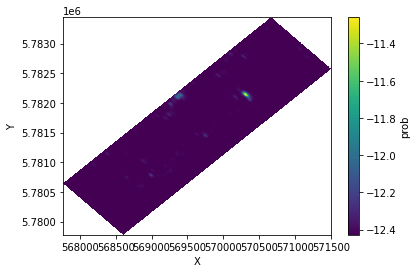

In [49]:
np.log(riskmap.prob).plot(x='X',y='Y')

Read foodprint 

In [75]:
newqq=xr.open_dataset('Original_Matlab/qq.nc')
newqq

<xarray.Dataset>
Dimensions:  (x: 36, y: 31)
Coordinates:
  * x        (x) int64 -25000 -24000 -23000 -22000 ... 7000 8000 9000 10000
  * y        (y) int64 -18000 -17000 -16000 -15000 ... 9000 10000 11000 12000
Data variables:
    prob     (x, y) float64 ...

In [72]:
riskmap.prob[20,10]

<xarray.DataArray 'prob' ()>
array(4.00357118e-06)
Coordinates:
    X        float32 5.679e+05
    Y        float32 5.781e+06

In [74]:
riskmap.prob[10,1000]

<xarray.DataArray 'prob' ()>
array(4.07129204e-06)
Coordinates:
    X        float32 5.701e+05
    Y        float32 5.783e+06

In [78]:
newqq.x+riskmap.prob[10,1000].X

<xarray.DataArray (x: 36)>
array([545063.25, 546063.25, 547063.25, 548063.25, 549063.25, 550063.25,
       551063.25, 552063.25, 553063.25, 554063.25, 555063.25, 556063.25,
       557063.25, 558063.25, 559063.25, 560063.25, 561063.25, 562063.25,
       563063.25, 564063.25, 565063.25, 566063.25, 567063.25, 568063.25,
       569063.25, 570063.25, 571063.25, 572063.25, 573063.25, 574063.25,
       575063.25, 576063.25, 577063.25, 578063.25, 579063.25, 580063.25])
Coordinates:
  * x        (x) int64 -25000 -24000 -23000 -22000 ... 7000 8000 9000 10000
    X        float32 5.701e+05
    Y        float32 5.783e+06